In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import svm_classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b', 'orange'
  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.3)
  plt.legend()
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
            
  plt.show()
  return vecs_2d

### Data loading & processing

In [3]:
def load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.wv.vectors), restrict_vocab=None)
    eps = 0.08
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]

    return group1, group2, neut

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)
    return vecs


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

In [4]:
# 50k top vectors (without gender-typical words) - used for training

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.with_biased.txt")

# only gendered vectors

model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")

# all 300k vectors
model_all = KeyedVectors.load_word2vec_format("../data/embeddings/GoogleNews-vectors-negative300-SLIM.bin", binary=True)


gender_direction = model_gendered["he"] - model_gendered["she"]
gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)

#gender_direction = model_gendered["he"] + model_gendered["man"] + model_gendered["boy"] + model_gendered["him"] - (model_gendered["she"] + model_gendered["woman"] + model_gendered["girl"] + model_gendered["her"])

masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model, n = 5000)
masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
fem_scores = [-x for x in fem_scores]
masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
neut_vecs = get_vectors(neut_words, model)

masc_words_and_scores_all, fem_words_and_scores_all, _ = project_on_gender_subspaces(gender_direction, model, n = 25000)
masc_words_all, _ = list(zip(*masc_words_and_scores))
fem_words_all, _ = list(zip(*fem_words_and_scores))
masc_vecs_all, fem_vecs_all = get_vectors(masc_words, model), get_vectors(fem_words, model)


#all_significantly_biased_words = masc_words + fem_words
#all_significantly_biased_vecs =  np.concatenate((masc_vecs, fem_vecs))
#all_significantly_biased_labels = np.concatenate((np.ones(fem_vecs.shape[0], dtype = int),
#                                                 np.zeros(masc_vecs.shape[0], dtype = int)))
#print(np.random.choice(masc_words, size = 75))
print(masc_words[:75])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print(fem_words[:75])

print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:75])


('journeyman', 'homeboy', 'He', 'hero', 'burly', 'goatee', 'rookie', 'affable', 'swashbuckling', 'maestro', 'scout', 'Irishman', 'jnr', 'buffoon', 'platooning', 'successor', 'madman', 'messiah', 'player', 'drafted', 'Englishman', 'legend', 'demigod', 'journeymen', 'playmaker', 'veteran', 'benching', 'players', 'hes', 'Groin', 'tradeable', 'snr', 'league', 'knucklehead', 'taciturn', 'bruiser', 'Kenny', 'mercurial', 'reinforcements', 'warhorse', 'superman', 'joker', 'platoon', 'legendary', 'stocky', 'serviceable', 'tinkerer', 'Snr', 'guys', 'team', 'catchable', 'tactician', 'showman', 'buddy', 'hothead', 'unspectacular', 'phlegmatic', 'genius', 'savior', 'mustachioed', 'gamble', 'dapper', 'sideburns', 'Doubtful', 'everyman', 'howitzer', 'Wily', 'laconic', 'tackle', 'talismanic', 'scouts', 'Kareem', 'Omar', 'suspension', 'scouting')
-------------------------
('Ann', 'Tyra', 'Aimee', 'Renee', 'girlhood', 'Heidi', 'Carrie', 'Keisha', 'Sophie', 'Tasha', 'Roxanne', 'Shanna', 'Lainey', 'Greta'

### Perform train-dev-test split

In [6]:
X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = -np.ones(fem_vecs.shape[0], dtype = int)
y_neut = np.zeros(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 6233; Dev size: 2672; Test size: 5937


### Debias

In [ ]:
REGRESSION = False
NUM_CLASSES = 2
EPSILON = 0.015

classifier_class = svm_classifier.SVMClassifier
num_classifiers = 50
input_dim = 300
is_autoregressive = True
min_accuracy = 0.0 #((1./NUM_CLASSES) + EPSILON) if not REGRESSION else 0.07
add_noise = False
random_sample = False
siamese = True

P = debias.get_debiasing_projection(classifier_class, num_classifiers, input_dim, 
                                    is_autoregressive, min_accuracy, X_train, Y_train,
                                    X_dev, Y_dev, add_noise, random_sample, REGRESSION, siamese)

I1124 16:22:35.697909 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 0, Accuracy: 0.7732036113739014


I1124 16:23:00.143362 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 1, Accuracy: 0.6931137442588806


I1124 16:23:22.108100 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 2, Accuracy: 0.6672903895378113


I1124 16:23:44.593975 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 3, Accuracy: 0.6541916131973267


I1124 16:24:07.345743 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 4, Accuracy: 0.6758981943130493


I1124 16:24:30.117554 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 5, Accuracy: 0.671407163143158


I1124 16:24:52.486587 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 6, Accuracy: 0.6665419340133667


I1124 16:25:15.496972 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 7, Accuracy: 0.6665419340133667


I1124 16:25:38.088597 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 8, Accuracy: 0.654940128326416


I1124 16:25:59.910109 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 9, Accuracy: 0.6646706461906433


I1124 16:26:21.967386 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 10, Accuracy: 0.6755239367485046


I1124 16:26:44.219496 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


Iteration 11, Accuracy: 0.6654191613197327


I1124 16:27:07.734600 140075304634176 root_module.py:322]                   Name     Type Params
0                    l   Linear  301  
1              sigmoid  Sigmoid    0  
2  binary_crossentropy  BCELoss    0  


### Test the quality of the debiasing.

#### Perform t-sne

909
886


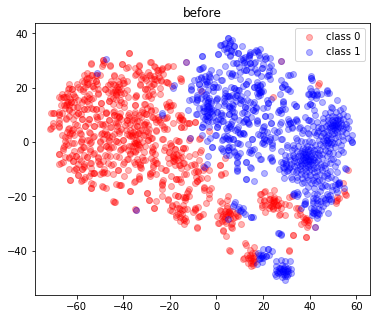

In [ ]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score
#print(Y_dev[:200])

def to_integer(arr, eps = 0.03):
    
    return np.array([1 if x > eps else (-1 if x < -eps else 0) for x in arr])
    
Y_dev = to_integer(Y_dev) #Y_dev > 0
Y_train = to_integer(Y_train)
X_dev = X_dev[Y_dev != 0]
X_train = X_train[Y_train != 0]
Y_dev = Y_dev[Y_dev != 0]
Y_train = Y_train[Y_train != 0]

tsne_by_gender(X_dev, Y_dev, title = "before")
X_dev_cleaned = X_dev.dot(P)
X_test_cleaned = X_test.dot(P)
X_trained_cleaned = X_train.dot(P)
#all_biased_cleaned = all_significantly_biased_vecs.dot(P)

tsne_projection = tsne_by_gender(X_dev_cleaned, Y_dev, title = "after")

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

NUM_CLUSTERS = [2,10,25,100]

print("CALCULATING BIAS BY CLUSTERING (WITH K-MENAS)")
for num_clusters in NUM_CLUSTERS:
    print("NUM CLUSTERS = {}".format(num_clusters))
    purity_original = perform_purity_test(X_dev, k = num_clusters, labels_true = Y_dev)
    purity_after = perform_purity_test(X_dev_cleaned, k = num_clusters, labels_true = Y_dev)
    print("Purity in original space: {}".format(purity_original))
    print("Purity after debiasing projection: {}".format(purity_after))

#### Train a nonlinear classifier for gender prediction.

In [9]:
#nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")
#nonlinear_clf = SGDClassifier(loss = "modified_huber", verbose = 0, max_iter = 5000, fit_intercept = True, class_weight = "balanced", penalty = "l2")
print("Before:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

print("After, rbf-svm:")
nonlinear_clf = SVC(kernel = "rbf")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

print("After, mlp:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

Before:
1.0
After, rbf-svm:
0.5064066852367688
After, mlp:
0.8974930362116992


#### project on the gender direction

In [11]:
masc_vecs_cleaned = masc_vecs.dot(P)
fem_vecs_cleaned = fem_vecs.dot(P)

print("masc-bias-before: {}".format(masc_vecs.dot(gender_unit_vec).mean()))
print("masc-bias-after: {}".format(masc_vecs_cleaned.dot(gender_unit_vec).mean()))
print("fem-bias-before: {}".format(fem_vecs.dot(gender_unit_vec).mean()))
print("fem-bias-after: {}".format(fem_vecs_cleaned.dot(gender_unit_vec).mean()))      

masc-bias-before: 0.1273171454668045
masc-bias-after: 0.000473397069639378
fem-bias-before: -0.21711118519306183
fem-bias-after: -0.0001116431443486709


#### calculate the similarity matrix before and after

In [12]:

def get_distance_matrix(vecs: np.ndarray):

  distances = sklearn.metrics.pairwise_distances(vecs, vecs, metric="cosine")
  return distances

def plot_distance(distance_before, distance_after):

    idx = distance_before < 0.75 # we are only interested in the relatively close words

    distance_before = distance_before.copy()[idx]
    distance_after = distance_after.copy()[idx]
    
    chosen = np.random.rand(len(distance_before)) < 0.01
    before = distance_before[chosen]
    after = distance_after[chosen]
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("distnace before")
    plt.ylabel("distance after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))
    
def plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after):

    K = 50
    most_similar_idx_before = distance_before.argsort(axis = 0)[:K].T
    most_similar_idx_after = distance_after.argsort(axis = 0)[:K].T
    data = []
    
    for i, (bias, dis_before, dis_after) in enumerate(tqdm.tqdm(zip(bias_before, distance_before, distance_after), ascii = True, total = len(bias_before))):
        
        idx_before = set(most_similar_idx_before[i].tolist())
        idx_after = set(most_similar_idx_after[i].tolist())
        intersection = (most_similar_idx_before[i] == most_similar_idx_after[i]).sum() 
        intersection = idx_before.intersection(idx_after)
        data.append((abs(bias), 1 - len(intersection)/K))
        #data.append((abs(bias), 1 - intersection/K))
        
    plt.xlabel("change in similarity (% of of top-{}-similar that changed)".format(K))
    plt.ylabel("bias before")
    biases, sims = zip(*data)    
    plt.plot(sims, biases, linestyle="None", marker = "*", alpha = 0.1)

    plt.show()
    print("Correlation: {}".format(pearsonr(biases, sims)[0]))

#### Plot similarity before vs. similarity after, and change of similarity vs. bias before

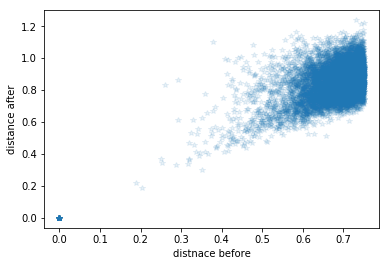

Correlation: 0.6667059420282303


100%|##########| 8030/8030 [00:00<00:00, 19455.19it/s]


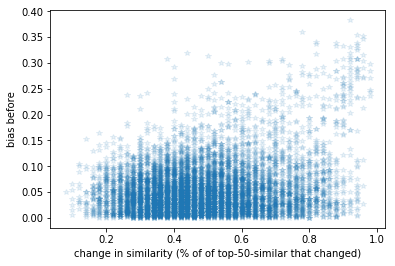

Correlation: 0.24766603748728963


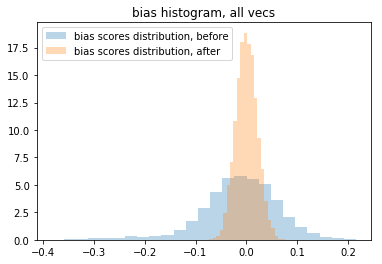

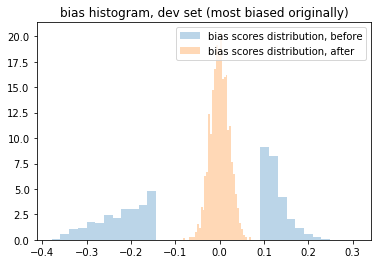

In [14]:
prop = 0.08
idx = np.random.rand(vecs.shape[0]) < prop
vecs_sample = vecs[idx]
words_sample = np.array(words, dtype = "object")[idx]

vecs_sample_cleaned = vecs_sample.dot(P)

distance_before = get_distance_matrix(vecs_sample)
distance_after = get_distance_matrix(vecs_sample_cleaned)

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
sample_normalized = vecs_sample/np.linalg.norm(vecs_sample, axis = 1, keepdims = True)
sample_cleaned_normalized = vecs_sample_cleaned/np.linalg.norm(vecs_sample_cleaned, axis = 1, keepdims = True)

bias_before = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample)[0] #sample_normalized.dot(gender_unit_vec)
bias_after = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample_cleaned)[0] #sample_normalized.dot(gender_unit_vec)

plot_distance(distance_before.reshape(-1), distance_after.reshape(-1))
plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after)

# plot bias histograms before and after

# all vecs

plt.hist(bias_before, bins = 25, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after, bins = 25, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, all vecs")
plt.show()

# most originally biased (dev set)

bias_before_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev)[0]
bias_after_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev.dot(P))[0]

plt.hist(bias_before_dev, bins = 35, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after_dev, bins = 35, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, dev set (most biased originally)")
plt.show()


In [15]:
vecs_cleaned = vecs.dot(P)
save_in_word2vec_format(vecs_cleaned, words, "../data/embeddings/vecs.50k.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.50k.cleaned.txt")

all_cleaned = model_all.wv.vectors.dot(P)
#print(all_cleaned.shape, len(list(model_all.wv.vocab.keys())))
save_in_word2vec_format(all_cleaned, list(model_all.wv.vocab.keys()), "../data/embeddings/all.cleaned.txt")
model_all_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/all.cleaned.txt")


100000it [00:22, 4383.85it/s]
I1124 16:15:08.957887 140368720709440 utils_any2vec.py:341] loading projection weights from ../data/embeddings/vecs.50k.cleaned.txt
W1124 16:15:08.961043 140368720709440 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead
I1124 16:15:35.351328 140368720709440 utils_any2vec.py:405] loaded (100000, 300) matrix from ../data/embeddings/vecs.50k.cleaned.txt
299567it [01:12, 4154.54it/s]
I1124 16:16:49.234775 140368720709440 utils_any2vec.py:341] loading projection weights from ../data/embeddings/all.cleaned.txt
W1124 16:16:49.237619 140368720709440 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead
I1124 16:18:15.379094 140368720709440 utils_any2vec.py:405] loaded (299567, 300) matrix from ../data/embeddings/all.cleaned.txt


#### calcualte the similarity of female-stereotyped words to 'girlish', before and after

In [16]:

w = "girlish"
k = 200

random_fem_words = np.random.choice(fem_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_fem_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_fem_words]

print("Similarity of female-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))


Similarity of female-stereotyped words to 'girlish' before: 0.19150449335575104; similarity after: 0.008081411011517048


### Calcualte bias-by-clustering

In [17]:
def numerical_bias_by_clustering(model_before, model_after, masc_words, fem_words, k):
    
    scores_before, scores_after = [], []
    all_biased = masc_words.union(fem_words)
    
    for w in all_biased:
        
        most_similar_before = model_before.most_similar(w, topn = k)
        most_similar_before, _ = zip(*most_similar_before)

        most_similar_after = model_after.most_similar(w, topn = k)
        most_similar_after, _ = zip(*most_similar_after)
        
        neighbors_biased_before = len([w for w in most_similar_before if w in all_biased])
        neighbors_biased_after = len([w for w in most_similar_after if w in all_biased])
        scores_before.append(neighbors_biased_before)
        scores_after.append(neighbors_biased_after)
    print("avg. number of biased neighbors before: {}; after: {}".format(np.mean(scores_before), np.mean(scores_after)))
    
    
    
    

In [18]:
#numerical_bias_by_clustering(model, model_cleaned, set(masc_words), set(fem_words), k = 1000)

#### print the most similar words to random words before and after (to make sure we didn't damage the space too much)

In [19]:
words_chosen = np.random.choice(words , size = 60)
topn = 8

for w in words_chosen:
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, _ = zip(*words_and_sims_before)
    words_after, _ = zip(*words__and_sims_after)
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")

I1124 16:18:36.431540 140368720709440 keyedvectors.py:1349] precomputing L2-norms of word weight vectors


w: passionless
 most-similar-before: ('uninspired', 'insipid', 'unimaginative', 'bland', 'humorless', 'charmless', 'vapid', 'turgid')
 most-similar-after: ('uninspired', 'bland', 'insipid', 'sexless', 'unimaginative', 'uninspiring', 'drab', 'unsatisfying')
----------------------------------
w: Nazar
 most-similar-before: ('Adil', 'Mohammad', 'Arif', 'Hadi', 'Sayed', 'Shahid', 'Masud', 'Syed')
 most-similar-after: ('Adil', 'Farhad', 'Mohammad', 'Rafiq', 'Mahmood', 'Ameer', 'Syed', 'Kamran')
----------------------------------
w: rescissions
 most-similar-before: ('rescission', 'Medicaid', 'uninsured', 'Medicare', 'premiums', 'insurers', 'earmarks', 'deductibles')
 most-similar-after: ('Medicare', 'Medicaid', 'rescission', 'overpayments', 'policyholders', 'uninsured', 'medicaid', 'premiums')
----------------------------------
w: abates
 most-similar-before: ('subsides', 'subside', 'abated', 'persists', 'worsens', 'abate', 'wanes', 'stabilizes')
 most-similar-after: ('subsides', 'abated', 

w: caress
 most-similar-before: ('caressing', 'caresses', 'caressed', 'tenderly', 'fondle', 'silken', 'sensual', 'sensuous')
 most-similar-after: ('caressing', 'caresses', 'fondle', 'caressed', 'cuddle', 'lick', 'clench', 'tenderly')
----------------------------------
w: Spokesmen
 most-similar-before: ('Spokespersons', 'Spokeswomen', 'spokeswomen', 'Officials', 'Separately', 'Neither', 'comment', 'spokesperson')
 most-similar-after: ('Spokespersons', 'Spokeswomen', 'spokeswomen', 'Separately', 'Neither', 'Officials', 'spokesperson', 'Spokeswoman')
----------------------------------
w: birthdate
 most-similar-before: ('birthdates', 'surname', 'name', 'aliases', 'identifiers', 'digits', 'birth', 'names')
 most-similar-after: ('birthdates', 'surname', 'identifiers', 'name', 'aliases', 'digits', 'names', 'surnames')
----------------------------------
w: Sancho
 most-similar-before: ('Cortes', 'Pedro', 'Alfonso', 'Fermin', 'Pepe', 'Mendez', 'Vicente', 'Pablo')
 most-similar-after: ('Ortega

### bias by profession experiment

In [20]:
def get_bias_by_neighbors(model, model_cleaned, gendered_words, v, gender_direction): 
    
    neighbors = model_cleaned.similar_by_vector(v, topn=100) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    return bias

def bias_by_profession(model, model_cleaned, gender_direction, P, masc_words):
    
    with codecs.open("../data/lists/professions.json") as f:
        professions_and_scores = json.load(f)

    professions = [p[0] for p in professions_and_scores]
    #print(professions)
    professions = list(filter(lambda p: p in model.wv, professions))
    vecs = np.array([model[p] for p in professions])
    vecs_cleaned = vecs.dot(P)
    bias_vals = np.array([model.cosine_similarities(gender_direction,vecs)])[0]
    #bias_vals_after = np.array([model.cosine_similarities(gender_direction,vecs_cleaned)])[0]
    bias_by_neighbors_after = np.array([get_bias_by_neighbors(model, model_cleaned, masc_words, v, gender_direction) for v in vecs_cleaned])
    bias_by_neighbors_before = np.array([get_bias_by_neighbors(model, model, masc_words, v, gender_direction) for v in vecs])

    #plt.ylim([np.min(bias_vals), np.max(bias_vals)])
    plt.plot(bias_vals, bias_by_neighbors_after, marker = "o", linestyle = "none", color = "red", label = "after", alpha = 0.25)
    plt.plot(bias_vals, bias_by_neighbors_before, marker = "o", linestyle = "none", color = "blue", label = "before", alpha = 0.25)
    
    word_idx_high = np.argsort(bias_vals)[:4] 
    word_idx_low = np.argsort(bias_vals)[-4:]
    word_idx_middle_low = np.argsort(bias_vals)[-55:-51]
    word_idx_middle_high = np.argsort(bias_vals)[51:55]
    words_biased_fem = [professions[i] for i in word_idx_high]
    words_biased_masc = [professions[i] for i in word_idx_low]
    mid_low = [professions[i] for i in word_idx_middle_low]
    mid_high = [professions[i] for i in word_idx_middle_high]
    words = words_biased_masc + words_biased_fem + mid_low + mid_high
    
    for w in words:
        i = professions.index(w)
        x1,y1 = bias_vals[i],bias_by_neighbors_after[i]
        plt.annotate(w , (x1,y1), size = 8, color = "red")
        x2,y2 = bias_vals[i],bias_by_neighbors_before[i]
        plt.annotate(w, (x2,y2), size = 8, color = "blue")
        #plt.arrow(x2,y2,x1-x2,y1-y2, width = 0.0005)
        
    plt.legend()
    plt.xlabel("bias-by-PROJECTION of the professions before")
    plt.ylabel("bias-by-NEIGHBORS")
    plt.title("projection bias before vs. neighbors bias before/after \n(# neighbors closer to 'she' then 'he')")
    plt.show()
    
    print("Correlation before: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_before)))
    print("Correlation after: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_after)))

        

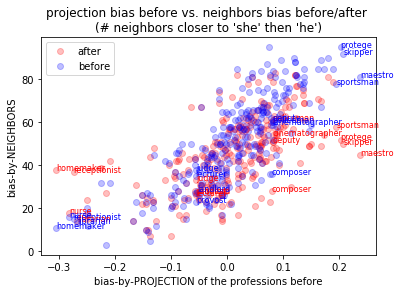

Correlation before: 0.7990152837701987, p-value: 4.962730823936054e-62
Correlation after: 0.6249195270227123, p-value: 4.365672906158786e-31


In [21]:
bias_by_profession(model, model_cleaned, gender_direction, P, fem_words_all)

In [42]:
"""
for i, (w,v,l) in enumerate(zip(all_significantly_biased_words,all_biased_cleaned,
                               all_significantly_biased_labels)):
    
    neighbors = model_cleaned.similar_by_vector(v, topn = 6, restrict_vocab=None)[1:]
    print(w, neighbors)
    print("===========================================")
 """

'\nfor i, (w,v,l) in enumerate(zip(all_significantly_biased_words,all_biased_cleaned,\n                               all_significantly_biased_labels)):\n    \n    neighbors = model_cleaned.similar_by_vector(v, topn = 6, restrict_vocab=None)[1:]\n    print(w, neighbors)\n    print("===========================================")\n '

### word association tests

In [22]:
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools


def s_word(w, A, B, model, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(model.similarity(w,a))
    for b in B:
        mean_b.append(model.similarity(w,b))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, model, all_s_words):
    
    total = 0
    for x in X:
        x_sim = s_word(x, A, B, model, all_s_words)
        total += x_sim
    for y in Y:
        y_sim =  s_word(y, A, B, model, all_s_words)
        total -= y_sim
    
    #print(x_sim, y_sim)
        
    return total


def p_value_exhust(X, Y, A, B, model):
    
    if len(X) > 10:
        print ('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, model, all_s_words)
    #print("s-orig: {}".format(s_orig))
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    #all_subs = set(itertools.combinations(union, subset_size))
    #print(all_subs)
    for subset in tqdm.tqdm(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    #print ('num of samples', total)
    return larger/float(total)


def p_value_sample(X, Y, A, B, model):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig = s_group(X, Y, A, B, model, all_s_words) 
    
    num_of_samples = min(10000, int(scipy.special.comb(length*2,length)*100))
    print ('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)

In [24]:
# Experiment 1

A = ['John', 'Paul', 'Mike', 'Kevin', 'Steve', 'Greg', 'Jeff', 'Bill']
B = ['Amy', 'Joan', 'Lisa', 'Sarah', 'Diana', 'Kate', 'Ann', 'Donna']
C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print (p_value_exhust(A, B, C, D, model_all_cleaned))

# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print (p_value_exhust(A, B, E, F, model_all_cleaned))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print (p_value_exhust(A, B, G, H, model_all_cleaned))

100%|██████████| 12870/12870 [00:00<00:00, 192968.75it/s]

0.9519036519036519
0.5740481740481741
0.9948717948717949


In [26]:
print(np.isclose(P.dot(P), P))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [23]:
    print(list(zip(P[0], P.dot(P)[0]))[:10])   

[(0.9714093840425351, 0.9714093841509807), (0.008571484731702873, 0.008571485159723773), (-0.01603695905324047, -0.016036958774188273), (-0.0032453532287818948, -0.003245352939306736), (0.0021152424492933562, 0.0021152420448067493), (0.007215143239578546, 0.007215143602261925), (-0.005644411956999392, -0.005644411961692271), (-0.009208392964386964, -0.009208393078747499), (-0.008856267895057222, -0.00885626732257076), (-0.013841615832938664, -0.013841615894735117)]
